# Minimum Time Optimal Control
Objective: perform a task in minimum time. For example:
* a robot manipulator reaching a target with the end-effector
* a mobile robot reaching a location

## Standard Problem Formulation
$$ \min_{X, U} \quad \sum_{k=0}^{N-1} l_k(x_k, u_k) + l_N(x_N)$$
$$\text{subject to} \quad x_{k+1} = f(x_k, u_k) \quad \forall k \in [0, N-1]$$
$$ \qquad \qquad g_k(x_k, u_k) \le 0 \qquad \forall k \in [0, N-1]$$
How to optimize for time?

## Option 1: Approximate Minimum Time
* Minimize "some distance" to target using **running cost**
* Push system to reach target as soon as possible
* Caveat: if distance computed with **2-norm**, robot could just get close to target w/o reaching it
    * **Gradient** of 2-norm goes to zero as the argument goes to zero
    * **1-norm** does not have this issue, but it's non-differentiable at zero

## Option 2: Variable Time Step
Make the time step $h$ a decision variable in the problem:
$$ \min_{X, U, h} \quad \sum_{k=0}^{N-1} l_k(x_k, u_k) + l_N(x_N) + w_{time} h$$
$$\text{subject to} \quad x_{k+1} = x_k + h \, f_c(x_k, u_k) \quad \forall k \in [0, N-1]$$
$$ \qquad \qquad g_k(x_k, u_k) \le 0 \qquad \forall k \in [0, N-1]$$
$$ h_{min} \le h \le h_{max} \qquad \qquad$$

### Benefits
* truly minimum-time problem

### Potential issues
* integrator accuracy depends on solution
* solver may exploit integration errors to artificially decrease cost 

# Minimum-Time Reaching with a Robot Manipulator
We use as state of the robot manipulator its joint positions and velocities:
$$ x = (q, \dot{q})$$
We model the dynamics as a double integrator:
$$ \ddot{q} = u $$

To ensure the joint torques $\tau$ remain within their limits, we use the Adam library to compute $\tau$ as a function of $(q, \dot{q}, \ddot{q})$:
$$\tau_{min} \le \text{inv_dyn}(q, \dot{q}, \ddot{q}) \le \tau_{max}$$
We use the Adam library also to compute the end-effector position as a function of $q$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from adam.casadi.computations import KinDynComputations
import casadi as cs
from time import time as clock
from time import sleep

import orc.utils.plot_utils as plut
from example_robot_data.robots_loader import load
import orc.optimal_control.casadi_adam.conf_ur5 as conf_ur5

In [2]:
robot = load("ur5")
joints_name_list = [s for s in robot.model.names[1:]] # skip the first name because it is "universe"
nq = len(joints_name_list)  # number of joints
nx = 2*nq                   # size of the state variable
kinDyn = KinDynComputations(robot.urdf, joints_name_list)

In [3]:
dt_min = 0.001      # min OCP time step
dt_max = 0.1        # max OCP time step
N = 150             # number of OCP time steps
q0 = np.zeros(nq)   # initial joint configuration
dq0= np.zeros(nq)   # initial joint velocities
x_init = np.concatenate([q0, dq0])
frame_name = "ee_link"
if(frame_name not in kinDyn.rbdalgos.model.links.keys()):
    print("ERROR. Frame name can only take values from this list")
ee_des = np.array([0, -0.45, 0]) # desired end-effector position
w_v = 0e-4          # velocity weight
w_a = 0e-6          # acceleration weight
w_time = 1          # cost for time minimization

In [4]:
# create the dynamics function
q   = cs.SX.sym('q', nq)
dq  = cs.SX.sym('dq', nq)
ddq = cs.SX.sym('ddq', nq)
state = cs.vertcat(q, dq)
rhs    = cs.vertcat(dq, ddq)
f = cs.Function('f', [state, ddq], [rhs])

In [5]:
# create a Casadi inverse dynamics function
H_b = cs.SX.eye(4)     # base configuration
v_b = cs.SX.zeros(6)   # base velocity
bias_forces = kinDyn.bias_force_fun()
mass_matrix = kinDyn.mass_matrix_fun()
# discard the first 6 elements because they are associated to the robot base
h = bias_forces(H_b, q, v_b, dq)[6:]
M = mass_matrix(H_b, q)[6:,6:]
tau = M @ ddq + h
inv_dyn = cs.Function('inv_dyn', [state, ddq], [tau])

In [6]:
# create a Casadi forward kinematics function
fk_fun = kinDyn.forward_kinematics_fun(frame_name)
ee_pos = fk_fun(H_b, q)[:3, 3]
fk = cs.Function('fk', [q], [ee_pos])

In [7]:
# pre-compute state and torque bounds
lbx = robot.model.lowerPositionLimit.tolist() + (-robot.model.velocityLimit).tolist()
ubx = robot.model.upperPositionLimit.tolist() + robot.model.velocityLimit.tolist()
tau_min = (-robot.model.effortLimit).tolist()
tau_max = robot.model.effortLimit.tolist()
print("dq max", robot.model.velocityLimit)
print("tau max", robot.model.effortLimit)

dq max [3.15 3.15 3.15 3.2  3.2  3.2 ]
tau max [150. 150. 150.  28.  28.  28.]


In [8]:
# create all the decision variables
opti = cs.Opti()
X, U = [], []
for k in range(N+1): 
    X += [opti.variable(nx)]
    opti.subject_to( opti.bounded(lbx, X[-1], ubx) )
for k in range(N): 
    U += [opti.variable(nq)]

dt = opti.variable(1)
opti.subject_to( opti.bounded(dt_min, dt, dt_max))

In [9]:
opti.subject_to(X[0] == x_init)
cost = 0.0
for k in range(N):     
    # Compute cost function
    ee_pos = fk(X[k][:nq])
    cost += w_v * X[k][nq:].T @ X[k][nq:] * dt
    cost += w_a * U[k].T @ U[k] * dt
    # uncomment the next line for adding a cost on ee distance to the target
#     cost += (ee_pos - ee_des).T @ (ee_pos - ee_des) * dt 

    # Add dynamics constraints
    opti.subject_to(X[k+1] == X[k] + dt * f(X[k], U[k]))

    # Add torque constraints
    opti.subject_to( opti.bounded(tau_min, inv_dyn(X[k], U[k]), tau_max))

In [10]:
# add the terminal constraints and cost on time
opti.subject_to(fk(X[-1][:nq]) == ee_des)
opti.subject_to(X[-1][nq:] == 0.0)
# opti.subject_to( dt == 0.005) # uncomment this line if you wanna fix time
cost += w_time * dt
opti.minimize(cost)

In [11]:
# Create the optimization problem
opts = {
    "ipopt.print_level": 0,
    "ipopt.tol": 1e-6,
    "ipopt.constr_viol_tol": 1e-6,
    "ipopt.compl_inf_tol": 1e-6,
    "print_time": 0,                # print information about execution time
    "detect_simple_bounds": True
}
opti.solver("ipopt", opts)

In [12]:
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [13]:
x_sol = np.array([sol.value(X[k]) for k in range(N+1)]).T
u_sol = np.array([sol.value(U[k]) for k in range(N)]).T
q_sol = x_sol[:nq,:]
dq_sol = x_sol[nq:,:]
dt_sol = sol.value(dt)
print(f"Optimized dt: {1e3*dt_sol:.1f} ms")
print(f"Horizon time: {N*dt_sol:.3f} s")

Optimized dt: 4.1 ms
Horizon time: 0.618 s


In [14]:
from orc.utils.robot_wrapper import RobotWrapper
from orc.utils.robot_simulator import RobotSimulator
from orc.utils.viz_utils import addViewerSphere, applyViewerConfiguration
import time

r = RobotWrapper(robot.model, robot.collision_model, robot.visual_model)
simu = RobotSimulator(conf_ur5, r)
simu.init(q0, dq0)
simu.display(q0)

REF_SPHERE_RADIUS = 0.05
EE_REF_SPHERE_COLOR = np.array([1, 0, 0, .5])
addViewerSphere(r.viz, 'world/ee_ref', REF_SPHERE_RADIUS, EE_REF_SPHERE_COLOR)

def display_motion(dt):
    for i in range(N):
        t0 = time.time()
        simu.display(q_sol[:,i])
        applyViewerConfiguration(r.viz, 'world/ee_ref', ee_des.tolist()+[0,0,0,1.])
        t1 = time.time()
        if(t1-t0 < dt_sol):
            sleep(dt_sol - (t1-t0))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [15]:
r.viz.viewer.jupyter_cell()

In [20]:
display_motion(dt_sol) 

In [17]:
# compute joint torques trajectory
tau = np.zeros((nq, N))
for i in range(N):
    tau[:,i] = inv_dyn(x_sol[:,i], u_sol[:,i]).toarray().squeeze()

In [18]:
# compute end-effector trajectory
ee = np.zeros((3, N+1))
for i in range(N+1):
    ee[:,i] = fk(x_sol[:nq,i]).toarray().squeeze()

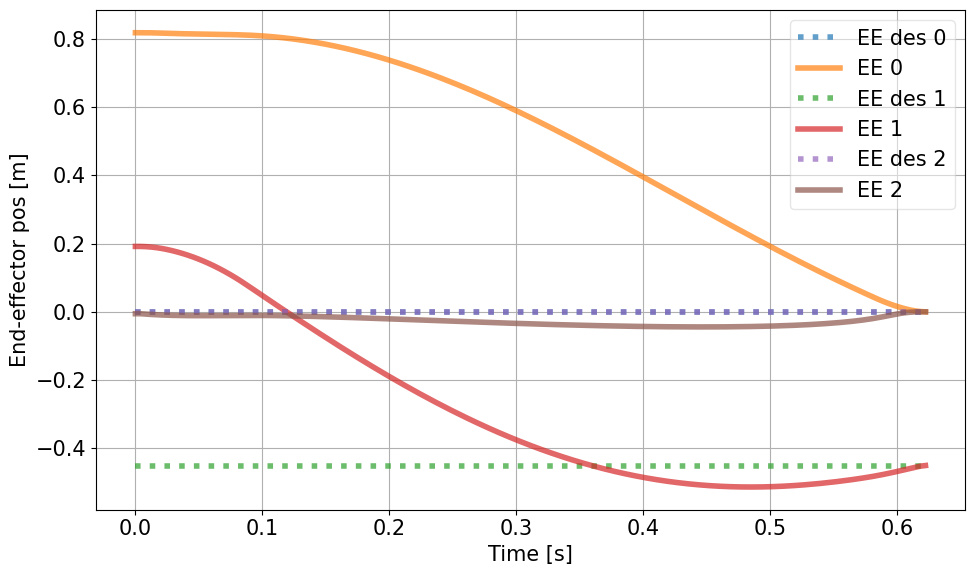

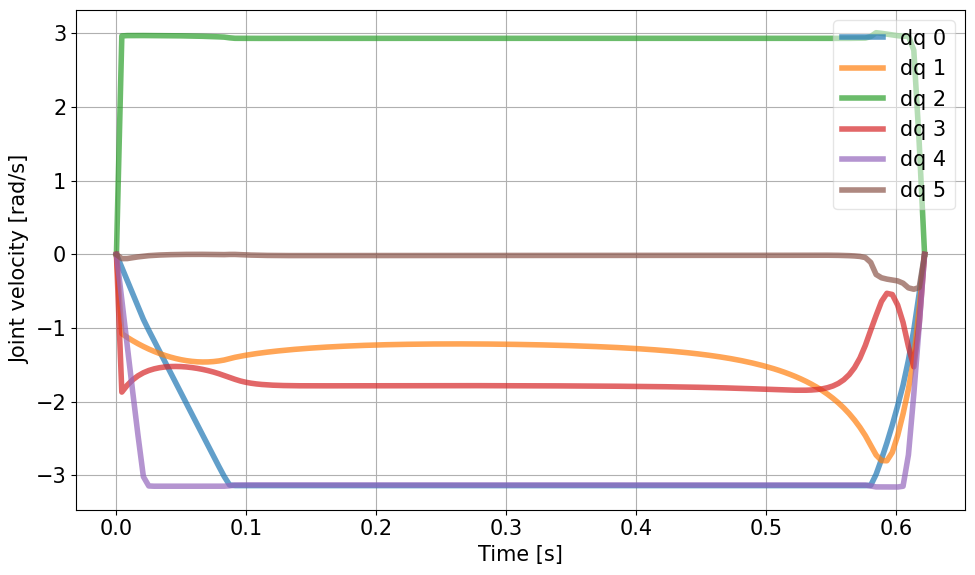

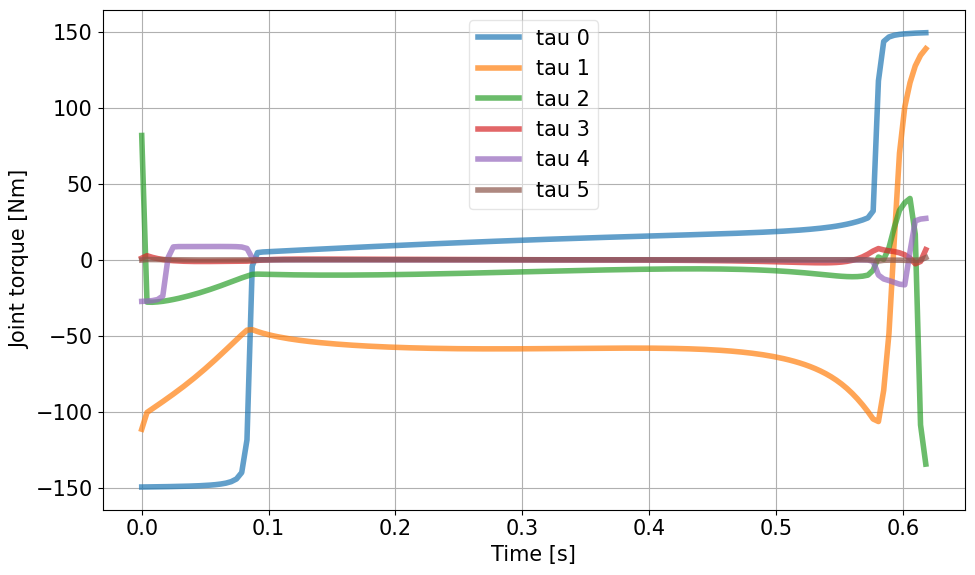

In [19]:
tt = np.linspace(0, (N+1)*dt_sol, N+1)

plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot([tt[0], tt[-1]], [ee_des[i], ee_des[i]], ':', label=f'EE des {i}', alpha=0.7)
    plt.plot(tt, ee[i,:].T, label=f'EE {i}', alpha=0.7)
plt.xlabel('Time [s]')
plt.ylabel('End-effector pos [m]')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
for i in range(dq_sol.shape[0]):
    plt.plot(tt, dq_sol[i,:].T, label=f'dq {i}', alpha=0.7)
plt.xlabel('Time [s]')
plt.ylabel('Joint velocity [rad/s]')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
for i in range(tau.shape[0]):
    plt.plot(tt[:-1], tau[i,:].T, label=f'tau {i}', alpha=0.7)
plt.xlabel('Time [s]')
plt.ylabel('Joint torque [Nm]')
plt.legend()
plt.grid(True)
plt.show()